SPDX-FileCopyrightText: 2025 Yoshitaka Hirata

SPDX-License-Identifier: BSD-3-Clause

This code was created as part of an assignment for the Advanced Vision course in graduate school.
Redistribution and use are permitted under the terms of the BSD 3-Clause License.

# 必要なライブラリ等をインポートと前処理


In [ ]:
!pip -q install scikit-learn


In [ ]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [ ]:
#モデルの再現性のために乱数のシードを固定
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
# MNISTの平均・標準偏差
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# train / test を両方DL
train_full = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)  # 60000
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)  # 10000

print("train_full:", len(train_full), "test_ds:", len(test_ds))


train_full: 60000 test_ds: 10000


In [ ]:
# 元の訓練データをtrain:val = 8:2に分割
train_len = int(len(train_full) * 0.8)  # 48,000
val_len   = len(train_full) - train_len  # 12,000

g = torch.Generator().manual_seed(42)

train_ds, val_ds = random_split(
    train_full,
    [train_len, val_len],
    generator=g
)

print("train / val:", len(train_ds), len(val_ds))

train / val: 48000 12000


# CNN構築と学習

In [ ]:
class OriginModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 5x5 Conv(6), pad=2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # 2x2 MaxPool, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5x5 Conv(16), pad=0
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        # 2x2 MaxPool, stride=2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 16 * 5 * 5 = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # 活性化関数
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)

        x = torch.flatten(x, 1)     # 平坦化
        x = self.act(self.fc1(x))   # FC(120)
        x = self.act(self.fc2(x))   # FC(84)
        x = self.fc3(x)             # FC(10)
        return x

model = OriginModel().to(device)
print(model)


OriginModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


In [ ]:
criterion = nn.CrossEntropyLoss()#交差エントロピー
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct, total = 0.0, 0, 0

    for img, label in loader:
        img = img.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * img.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == label).sum().item()
        total += img.size(0)

    return loss_sum / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    for img, label in loader:
        img = img.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)

        logits = model(img)
        loss = criterion(logits, label)

        loss_sum += loss.item() * img.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == label).sum().item()
        total += img.size(0)

    return loss_sum / total, correct / total


In [ ]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
#学習回数
EPOCHS = 5

train_losses, train_accs = [], []
val_losses, val_accs     = [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(va_loss);   val_accs.append(va_acc)

    print(f"[Epoch {epoch:02d}] "
          f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f}, val_acc={va_acc:.4f}")


[Epoch 01] train_loss=0.3592, train_acc=0.8909 | val_loss=0.1271, val_acc=0.9612
[Epoch 02] train_loss=0.0919, train_acc=0.9708 | val_loss=0.0839, val_acc=0.9728
[Epoch 03] train_loss=0.0631, train_acc=0.9800 | val_loss=0.0656, val_acc=0.9798
[Epoch 04] train_loss=0.0489, train_acc=0.9842 | val_loss=0.0664, val_acc=0.9792
[Epoch 05] train_loss=0.0396, train_acc=0.9876 | val_loss=0.0557, val_acc=0.9818


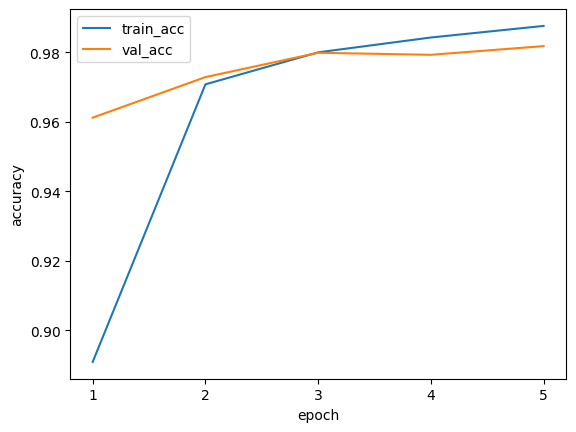

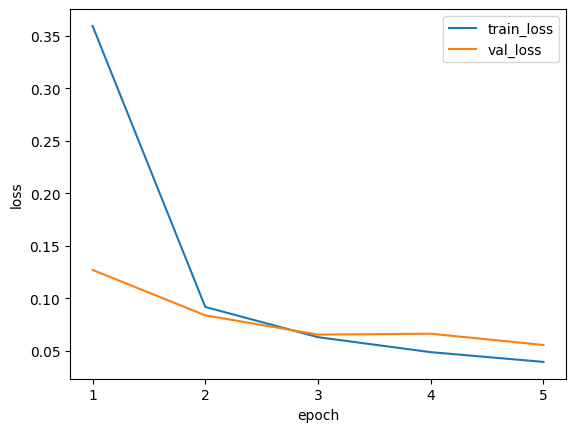

In [ ]:
epochs = range(1, EPOCHS + 1)

# 精度
plt.figure()
plt.plot(epochs, train_accs, label="train_acc")
plt.plot(epochs, val_accs, label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()

# 損失
plt.figure()
plt.plot(epochs, train_losses, label="train_loss")
plt.plot(epochs, val_losses, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(epochs)
plt.legend()
plt.show()


# モデルテスト

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"TEST: loss={test_loss:.4f}, acc={test_acc:.4f}")


TEST: loss=0.0457, acc=0.9850


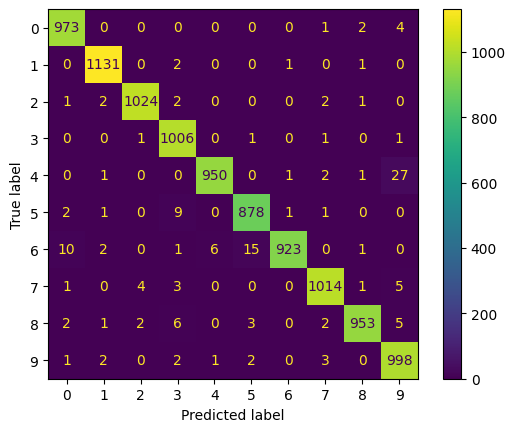

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    for img, label in loader:
        img = img.to(device, non_blocking=True)
        logits = model(img)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(label.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

preds, labels = get_all_preds(model, test_loader, device)

cm = confusion_matrix(labels, preds, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(values_format="d")
plt.show()


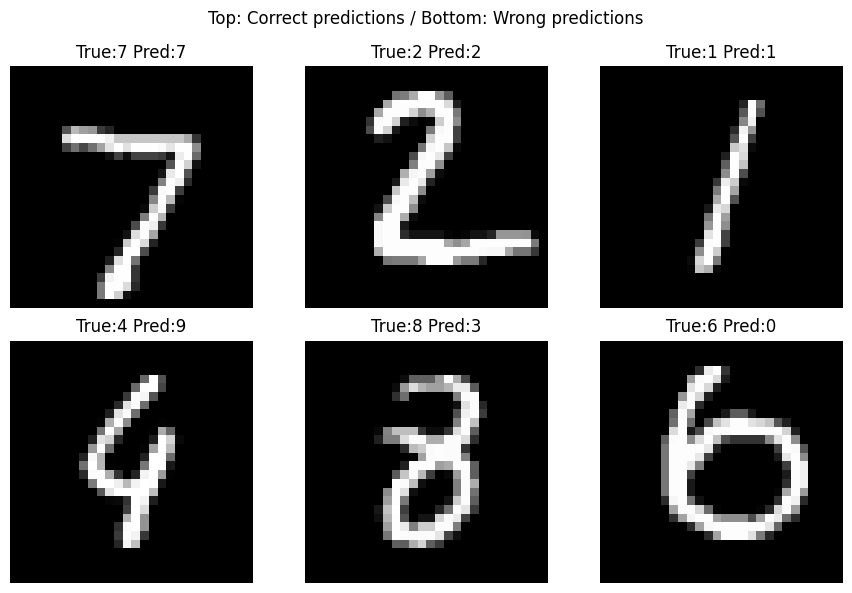

In [ ]:
# 成功例・失敗例の可視化

# 結果を取得
img_all, label_all = next(iter(DataLoader(
    test_loader.dataset,
    batch_size=len(test_loader.dataset),
    shuffle=False
)))
img_all = img_all.to(device)

with torch.no_grad():
    logits_all = model(img_all)
    preds_all = logits_all.argmax(dim=1).cpu()

correct_idx = (preds_all == label_all).nonzero(as_tuple=True)[0]
wrong_idx   = (preds_all != label_all).nonzero(as_tuple=True)[0]

# 表示
num_show = 3

plt.figure(figsize=(9, 6))

# 成功例
for i in range(num_show):
    idx = correct_idx[i].item()
    plt.subplot(2, num_show, i + 1)
    img = img_all[idx].cpu().squeeze(0).numpy()
    plt.imshow(img, cmap="gray")
    plt.title(f"True:{label_all[idx]} Pred:{preds_all[idx]}")
    plt.axis("off")

# 失敗例
for i in range(num_show):
    idx = wrong_idx[i].item()
    plt.subplot(2, num_show, num_show + i + 1)
    img = img_all[idx].cpu().squeeze(0).numpy()
    plt.imshow(img, cmap="gray")
    plt.title(f"True:{label_all[idx]} Pred:{preds_all[idx]}")
    plt.axis("off")

plt.suptitle("Top: Correct predictions / Bottom: Wrong predictions")
plt.tight_layout()
plt.show()
